In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
# matplotlib.rcParams['figure.figsize'] = [17, 4]
matplotlib.rcParams['axes.grid'] = True

In [2]:
# !pip install --upgrade pip --proxy=https://web-proxy.labs.hpecorp.net:8088
import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [3]:
import sys
sys.path.insert(0, '../')

from lib_data import *
from lib_nn_dpe import NN_dpe

In [4]:
load_workspace(vars(), '../data/20190821-051552-mnist_xs')

load_workspace(vars(), '../data/20200130-100802-mnist_config')

c:\users\can\.venv\py37\lib\site-packages\dill\_dill.py:472: UserWarning: This figure was saved with matplotlib version 3.1.1 and is unlikely to function correctly.
  obj = StockUnpickler.load(self)


Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 
Loaded: xs, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, finalGconv, weights, 


In [5]:
del train_images
del train_labels
# del test_images
# del test_labels
del xs

In [6]:
from lib_ecc import *

## Construct NN

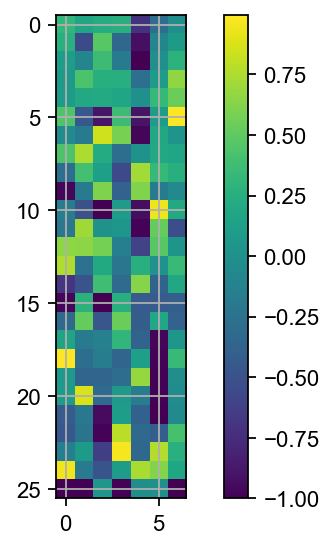

In [7]:
nn = NN_dpe(weights)

nn.Gratio = 100e-6

plt.imshow(nn.Mconv); plt.colorbar()

In [8]:
nn.Gratio

0.0001

## ECC matrix

7 4.0 7.0
The number of redundancy column is chosen to be the smallest even number 8
(26, 15)


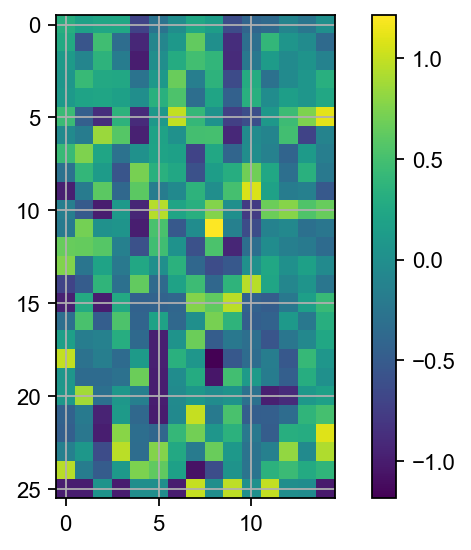

In [9]:
from dpeECC import dpeECC

delta = 1
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

print(k, np.ceil(np.sqrt(k+1))+1, 2*k/(np.floor(Delta/(2*delta))-2))

ecc = dpeECC(nn.Mconv, delta, Delta)
M_conv_ecc = ecc.encode()

print('The number of redundancy column is chosen to be the smallest even number', ecc.r)
print(M_conv_ecc.shape)

plt.imshow(M_conv_ecc); plt.colorbar()

Convert to conductance

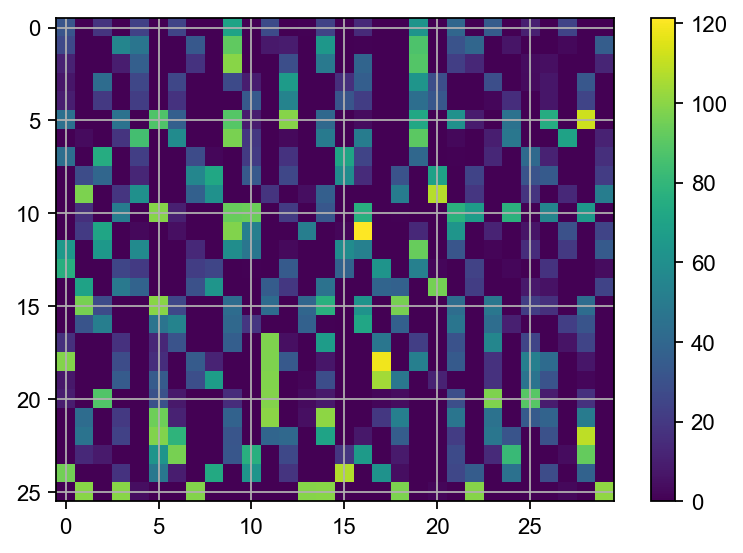

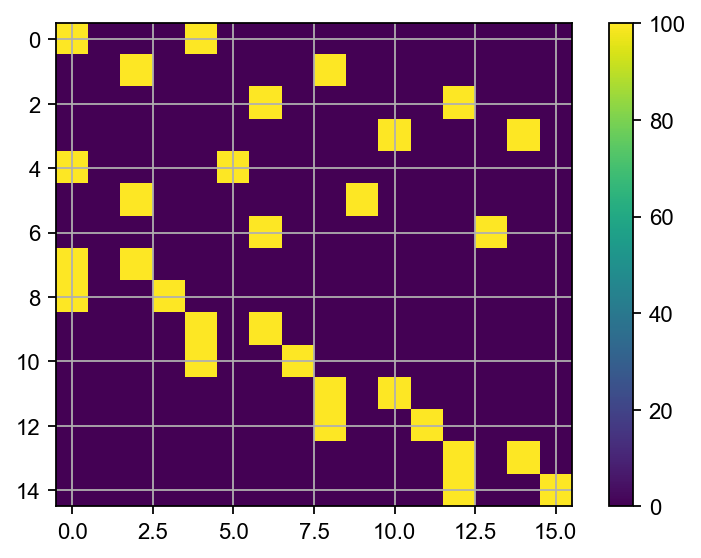

In [10]:
G_conv_ecc = weight2conductance(M_conv_ecc)
G_parity_ecc = weight2conductance(ecc.H.T)

plt.figure(1)
plt.imshow(G_conv_ecc * 1e6); plt.colorbar()

plt.figure(2)
plt.imshow(G_parity_ecc * 1e6); plt.colorbar()

## Program the array

In [7]:
from dpe import DPE

dpe = DPE('COM3')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


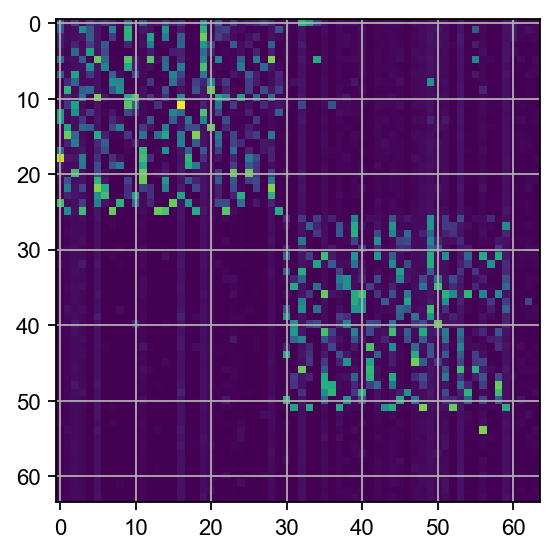

In [12]:
g = dpe.read(1, method='fast')
plt.imshow(g)

In [13]:
Gtarget = np.zeros((64,64))

Gtarget[20:20+G_conv_ecc.shape[0], 20:20+G_conv_ecc.shape[1]] = G_conv_ecc

Msel = np.zeros((64,64))
Msel[20:,20:] = 1
# Msel[Gtarget<4e-6] = 0

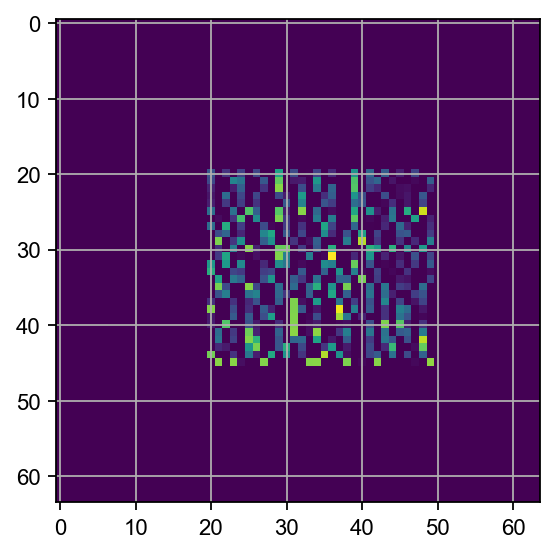

In [14]:
plt.imshow(Gtarget)

In [198]:
data = dpe.tune_conductance(0,  Gtarget, saveHistory=True, maxSteps=1000, method='fast',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 1.5, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=1e-3,  Msel=Msel, Gtol_in=4e-6, Gtol_out=10e-6, numReads=3)

Start programming, step=180, maxBound=139 yield= 88.48% - 98.19%
1.0 devices to be programmed...reset 140.0, set 0.0
Setting 0 devices...
Programming with external timing Twidth=10.000 us
Resetting 1 devices...
Programming with external timing Twidth=1000.000 us
------------------------------
Programming completed.


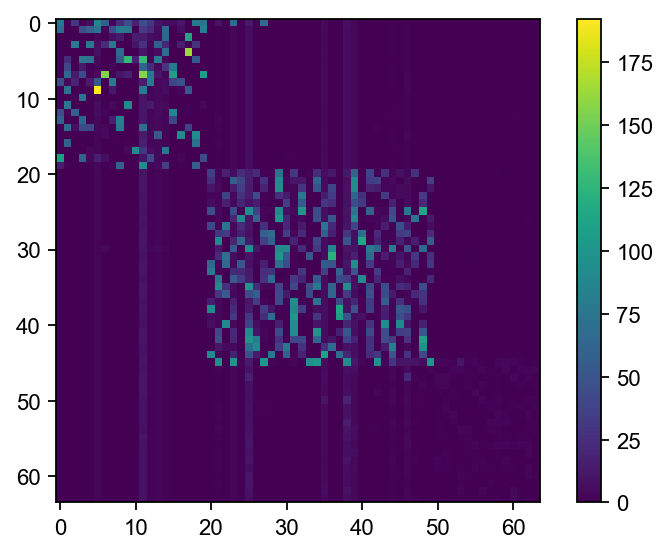

In [199]:
g2 = dpe.read(0, method='fast')
plt.imshow(g2*1e6); plt.colorbar()
plt.grid(False)

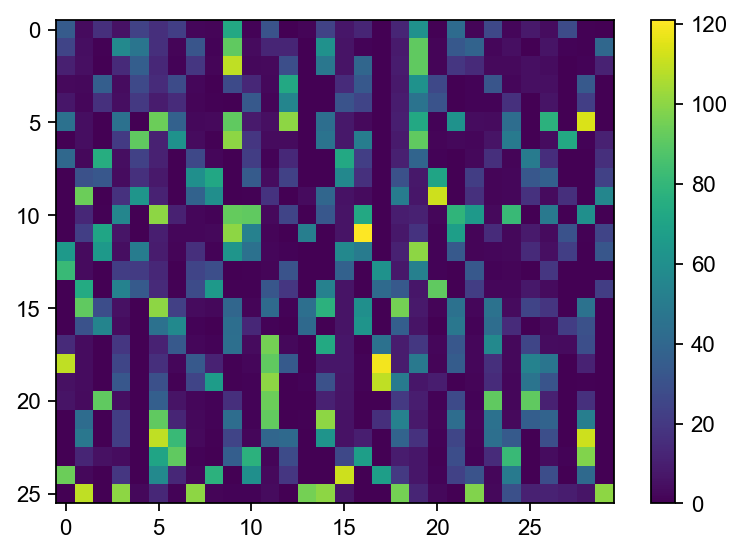

In [200]:
g2 = dpe.read(0, method='fast')

plt.imshow(g2[20:20+G_conv_ecc.shape[0], 20:20+G_conv_ecc.shape[1]]*1e6); plt.colorbar()
plt.grid(False)

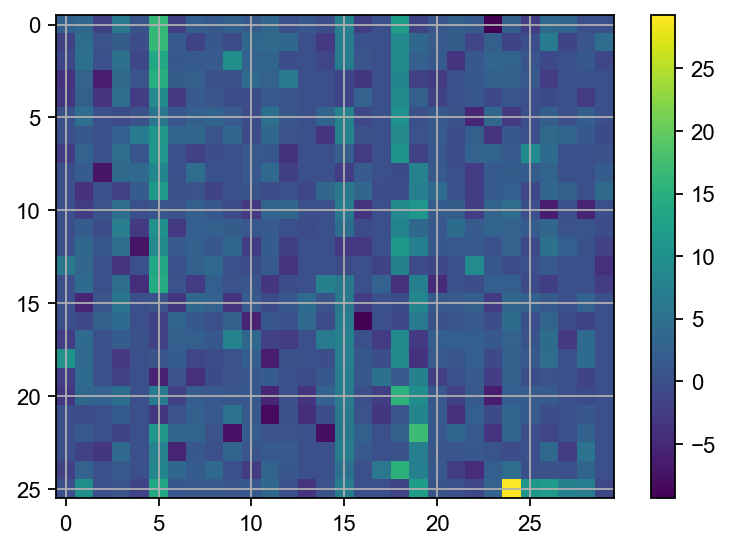

In [201]:
plt.imshow((g2-Gtarget)[20:20+G_conv_ecc.shape[0], 20:20+G_conv_ecc.shape[1]]* 1e6 )
plt.colorbar()

In [202]:
data = dpe.tune_conductance(0,  Gtarget, saveHistory=True, maxSteps=300, method='fast',
                           vSetRamp=[1, 4, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 2.2, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=10e-3,  Msel=Msel, Gtol_in=20e-6, Gtol_out=30e-6, numReads=3)

Start programming, step=19, maxBound=0 yield= 99.95% - 100.00%
1.0 devices to be programmed...reset 1.0, set 0.0
Setting 0 devices...
Programming with external timing Twidth=10.000 us
Resetting 1 devices...
Programming with external timing Twidth=10000.000 us
------------------------------
Programming completed.


In [203]:
Msel = np.zeros((64,64))
Msel[20:,20:] = 1

Text(0, 0.5, 'Count')

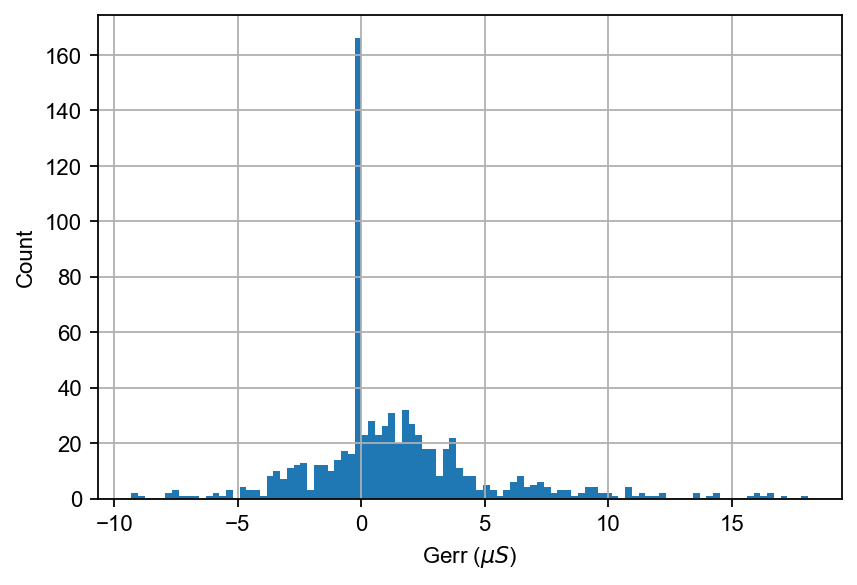

In [204]:
g2 = dpe.read(0, method='fast')

gdiff = (g2-Gtarget)[20:20+G_conv_ecc.shape[0], 20:20+G_conv_ecc.shape[1]]* 1e6 

_ = plt.hist((gdiff.reshape(-1)), 100)

plt.xlabel('Gerr ($\mu S$)')
plt.ylabel('Count')

# plt.xlim((-30, 30))

## Linear correction with a CNN test

In [205]:
i = 0

N_IMG = 1

vectors_list = []
output_list = []

for img, lab in tqdm(zip(test_images, test_labels), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
    vectors_list.append(vectors)
    output_list.append(output)
    
    if i >= N_IMG:
        break

In [206]:
vectors = np.concatenate(vectors_list, axis=1)
output = np.concatenate(output_list, axis=0)

In [207]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio

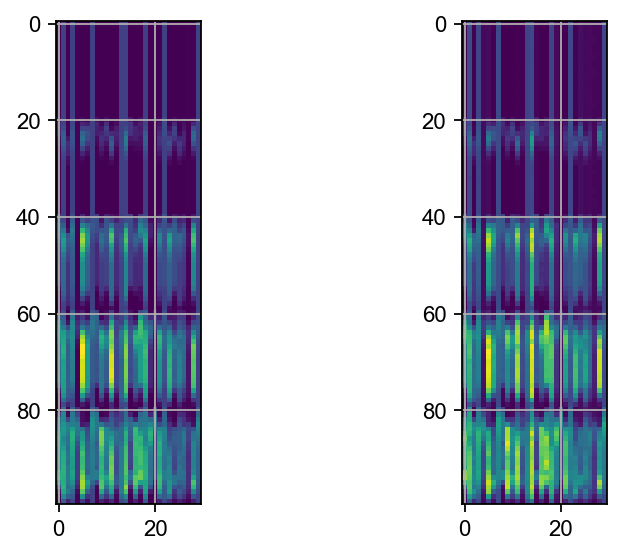

In [208]:
plt.subplot(121)
plt.imshow(output_soft[:100])

plt.subplot(122)
plt.imshow(output[:100])

Core output

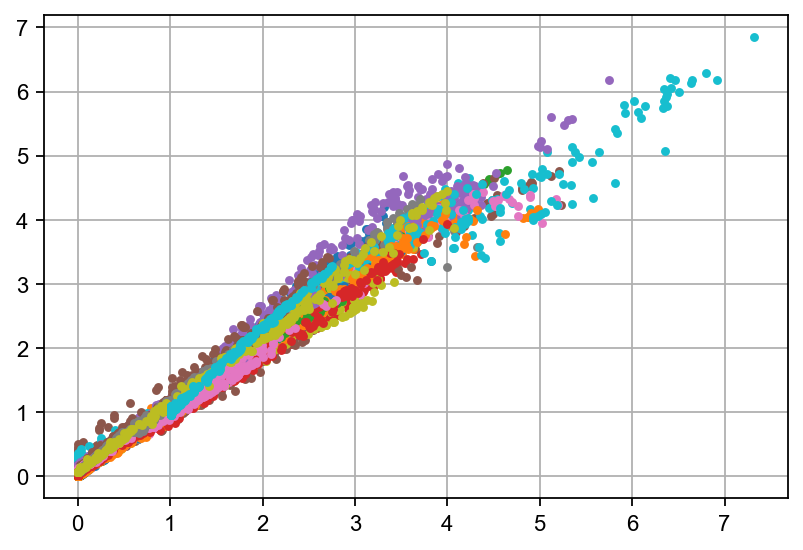

In [209]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output[:,c], '.')

Linear correction

In [214]:
lin_cor_conv = []
for c in range(output.shape[1]):
    lin_cor_conv.append( np.polyfit(output[:,c], output_soft[:,c], 1))

In [215]:
output_cor = dpe.lin_corr(output, lin_cor_conv)

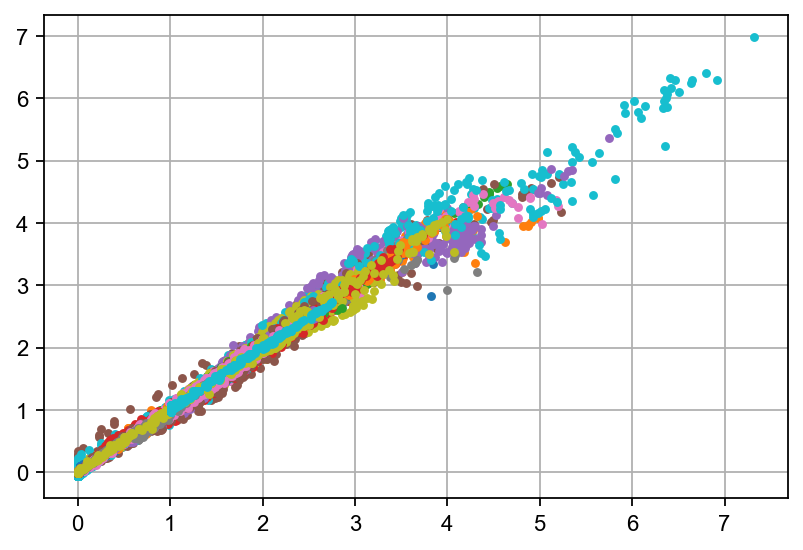

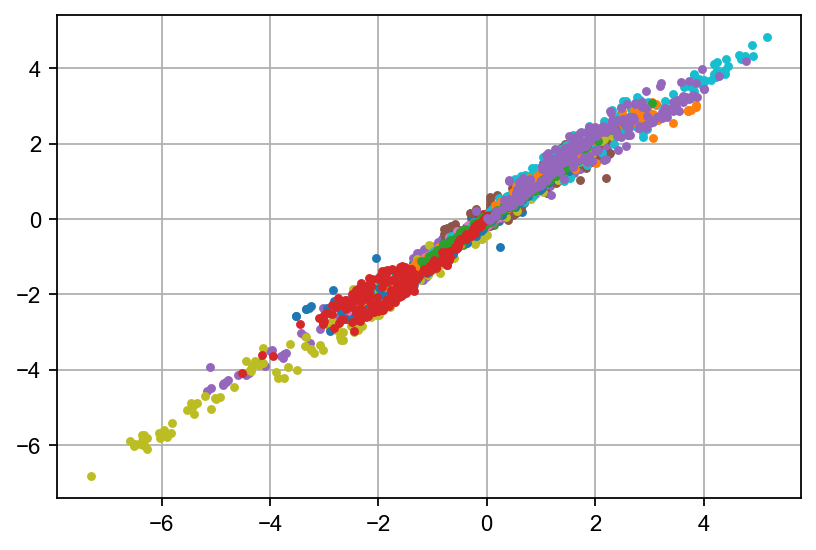

In [216]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output_cor[:,c], '.')
    
plt.figure()
for c in range(output.shape[1]//2):
    plt.plot(output_soft[:,c] - output_soft[:,c+1], 
             output_cor[:,c]  - output_cor[:,c+1], '.'
            )

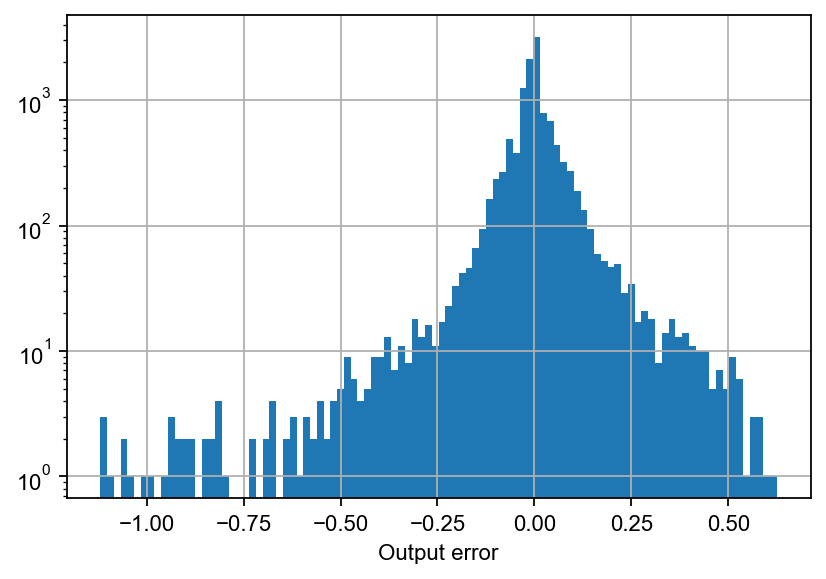

In [217]:
_ = plt.hist((output_cor - output_soft ).reshape(-1), 100)
plt.xlabel('Output error')

plt.yscale('log')

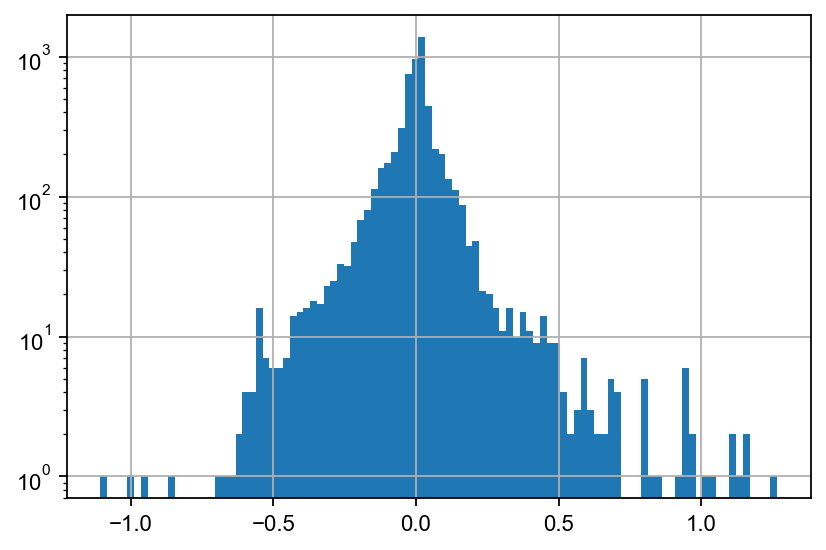

In [218]:
_ = plt.hist(((output_cor[:,::2]-output_cor[:,1::2]) -
             (output_soft[:,::2]- output_soft[:,1::2]) ).reshape(-1), 100)

plt.yscale('log')

In [219]:
# save_workspace(vars(), note='programming1', skip_mat=True)

## Plot the difference

In [222]:
delta = 0.15
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

ecc = dpeECC(nn.Mconv, delta, Delta)

In [223]:
i = 0

n_detected = 0
n_corrected = 0
n_other = 0

y_pred = []

y1_raw_list = []
y1_ecc_list = []
y1_soft_list = []

N_IMG = 1

for img, lab in tqdm(zip(test_images[:N_IMG], test_labels[:N_IMG]), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    
    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
#     Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)
    
    y1 = output[:, ::2] - output[:, 1::2]
    
    output_soft = vectors.T @ G_conv_ecc / nn.Gratio
    y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]
    
    y1_raw_list.append(y1.copy())
    y1_soft_list.append(y1_soft.copy())
    
    # ECC
    S = (y1 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]

    for s, yy in zip(S, y1):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)
        
        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1
                
            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
            else:
                n_other += 1
                
    y1_ecc_list.append(y1.copy())
    
    
    k = nn.Gconv.shape[1] //2
    
    x = y1[:, :k]

    x = x.reshape(20, 20, -1)

    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    x1 = np.append(x1, 1)

    y = x1.T @ finalGfc
    y = y[::2] - y[1::2]

    y_pred.append(y.argmax())
    

In [224]:
n_detected, n_corrected, n_other

(64, 28, 0)

In [225]:
# y1_raw = np.array(y1_raw_list)[:,:,0]
# y1_soft = np.array(y1_soft_list)[:,:,0]
# y1_ecc = np.array(y1_ecc_list)[:,:,0]

y1_raw = np.array(y1_raw_list)
y1_soft = np.array(y1_soft_list)
y1_ecc = np.array(y1_ecc_list)

(-1.5, 1.5)

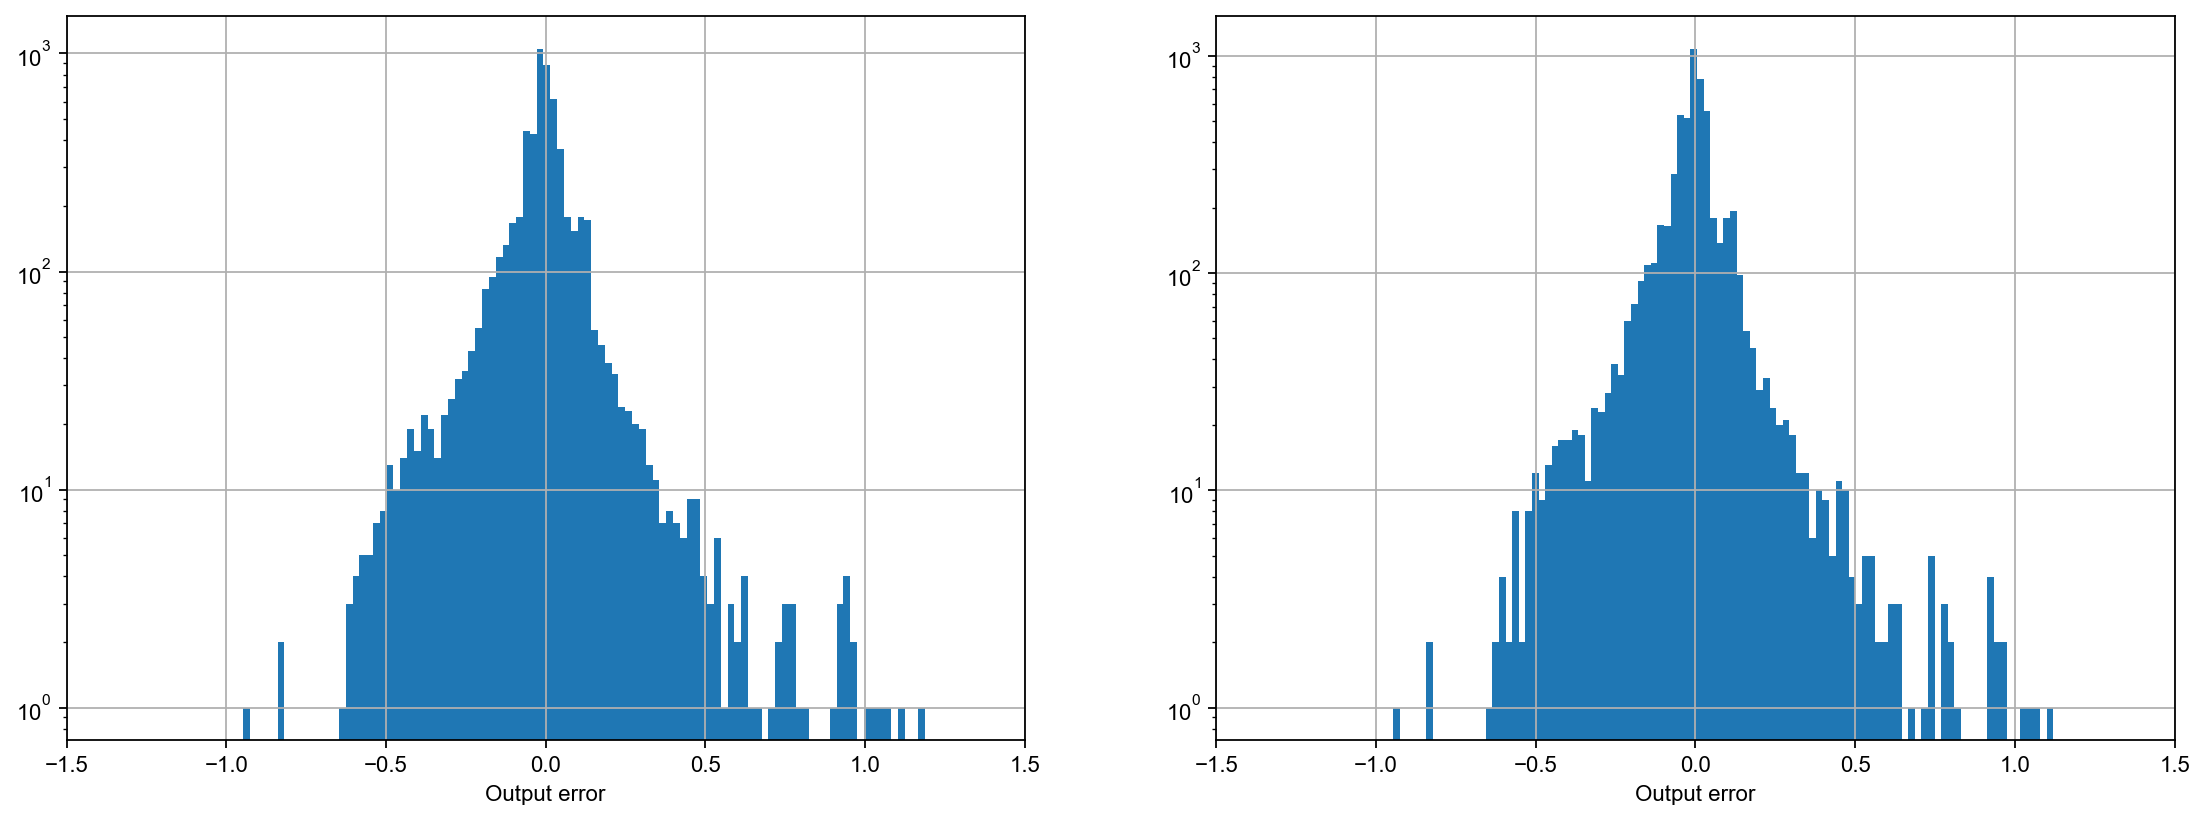

In [226]:
plt.figure(figsize=(17, 6))

plt.subplot(1,2,1)

_ = plt.hist((y1_raw - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-1.5,1.5))

plt.subplot(1,2,2)
_ = plt.hist((y1_ecc - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-1.5,1.5))

In [227]:
err_raw = (y1_raw - y1_soft).reshape(-1)

np.std(err_raw)

0.14340586381853662

In [228]:
err_ecc = (y1_ecc - y1_soft).reshape(-1)

np.std(err_ecc)

0.14258182136305703

Text(0, 0.5, 'Cummulative number of error')

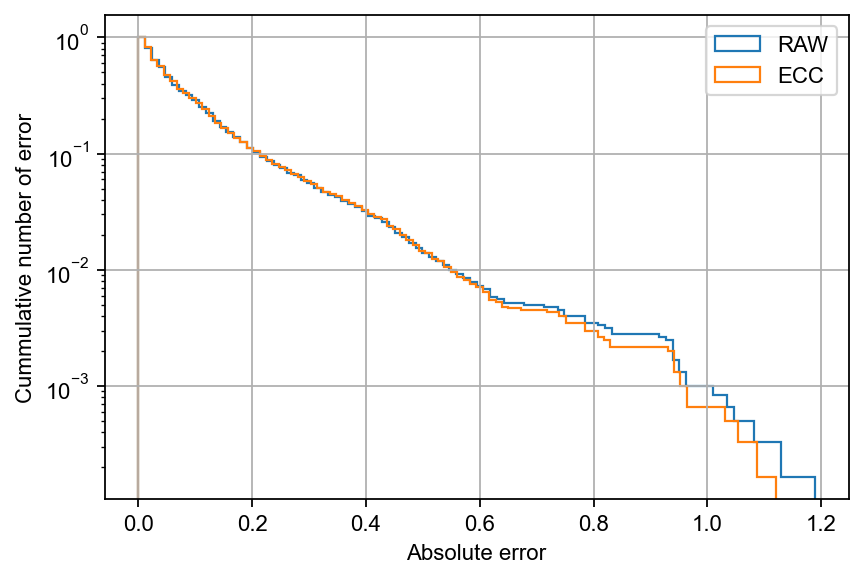

In [229]:
_ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
        label='RAW', bins=100)

_ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
        label='ECC', bins=100)

plt.legend()

plt.yscale('log')

plt.xlabel('Absolute error')
plt.ylabel('Cummulative number of error')

## Explore delta parameter in software

In [230]:
from lib_ecc import *

In [231]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list_list = []

for delta in tqdm(delta_list):
    y1_ecc_list = []
    
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

    for y1_raw in y1_raw_list:
        y1_ecc_list.append( correct_ecc(y1_raw, ecc) )
        
    y1_ecc_list_list.append(y1_ecc_list)

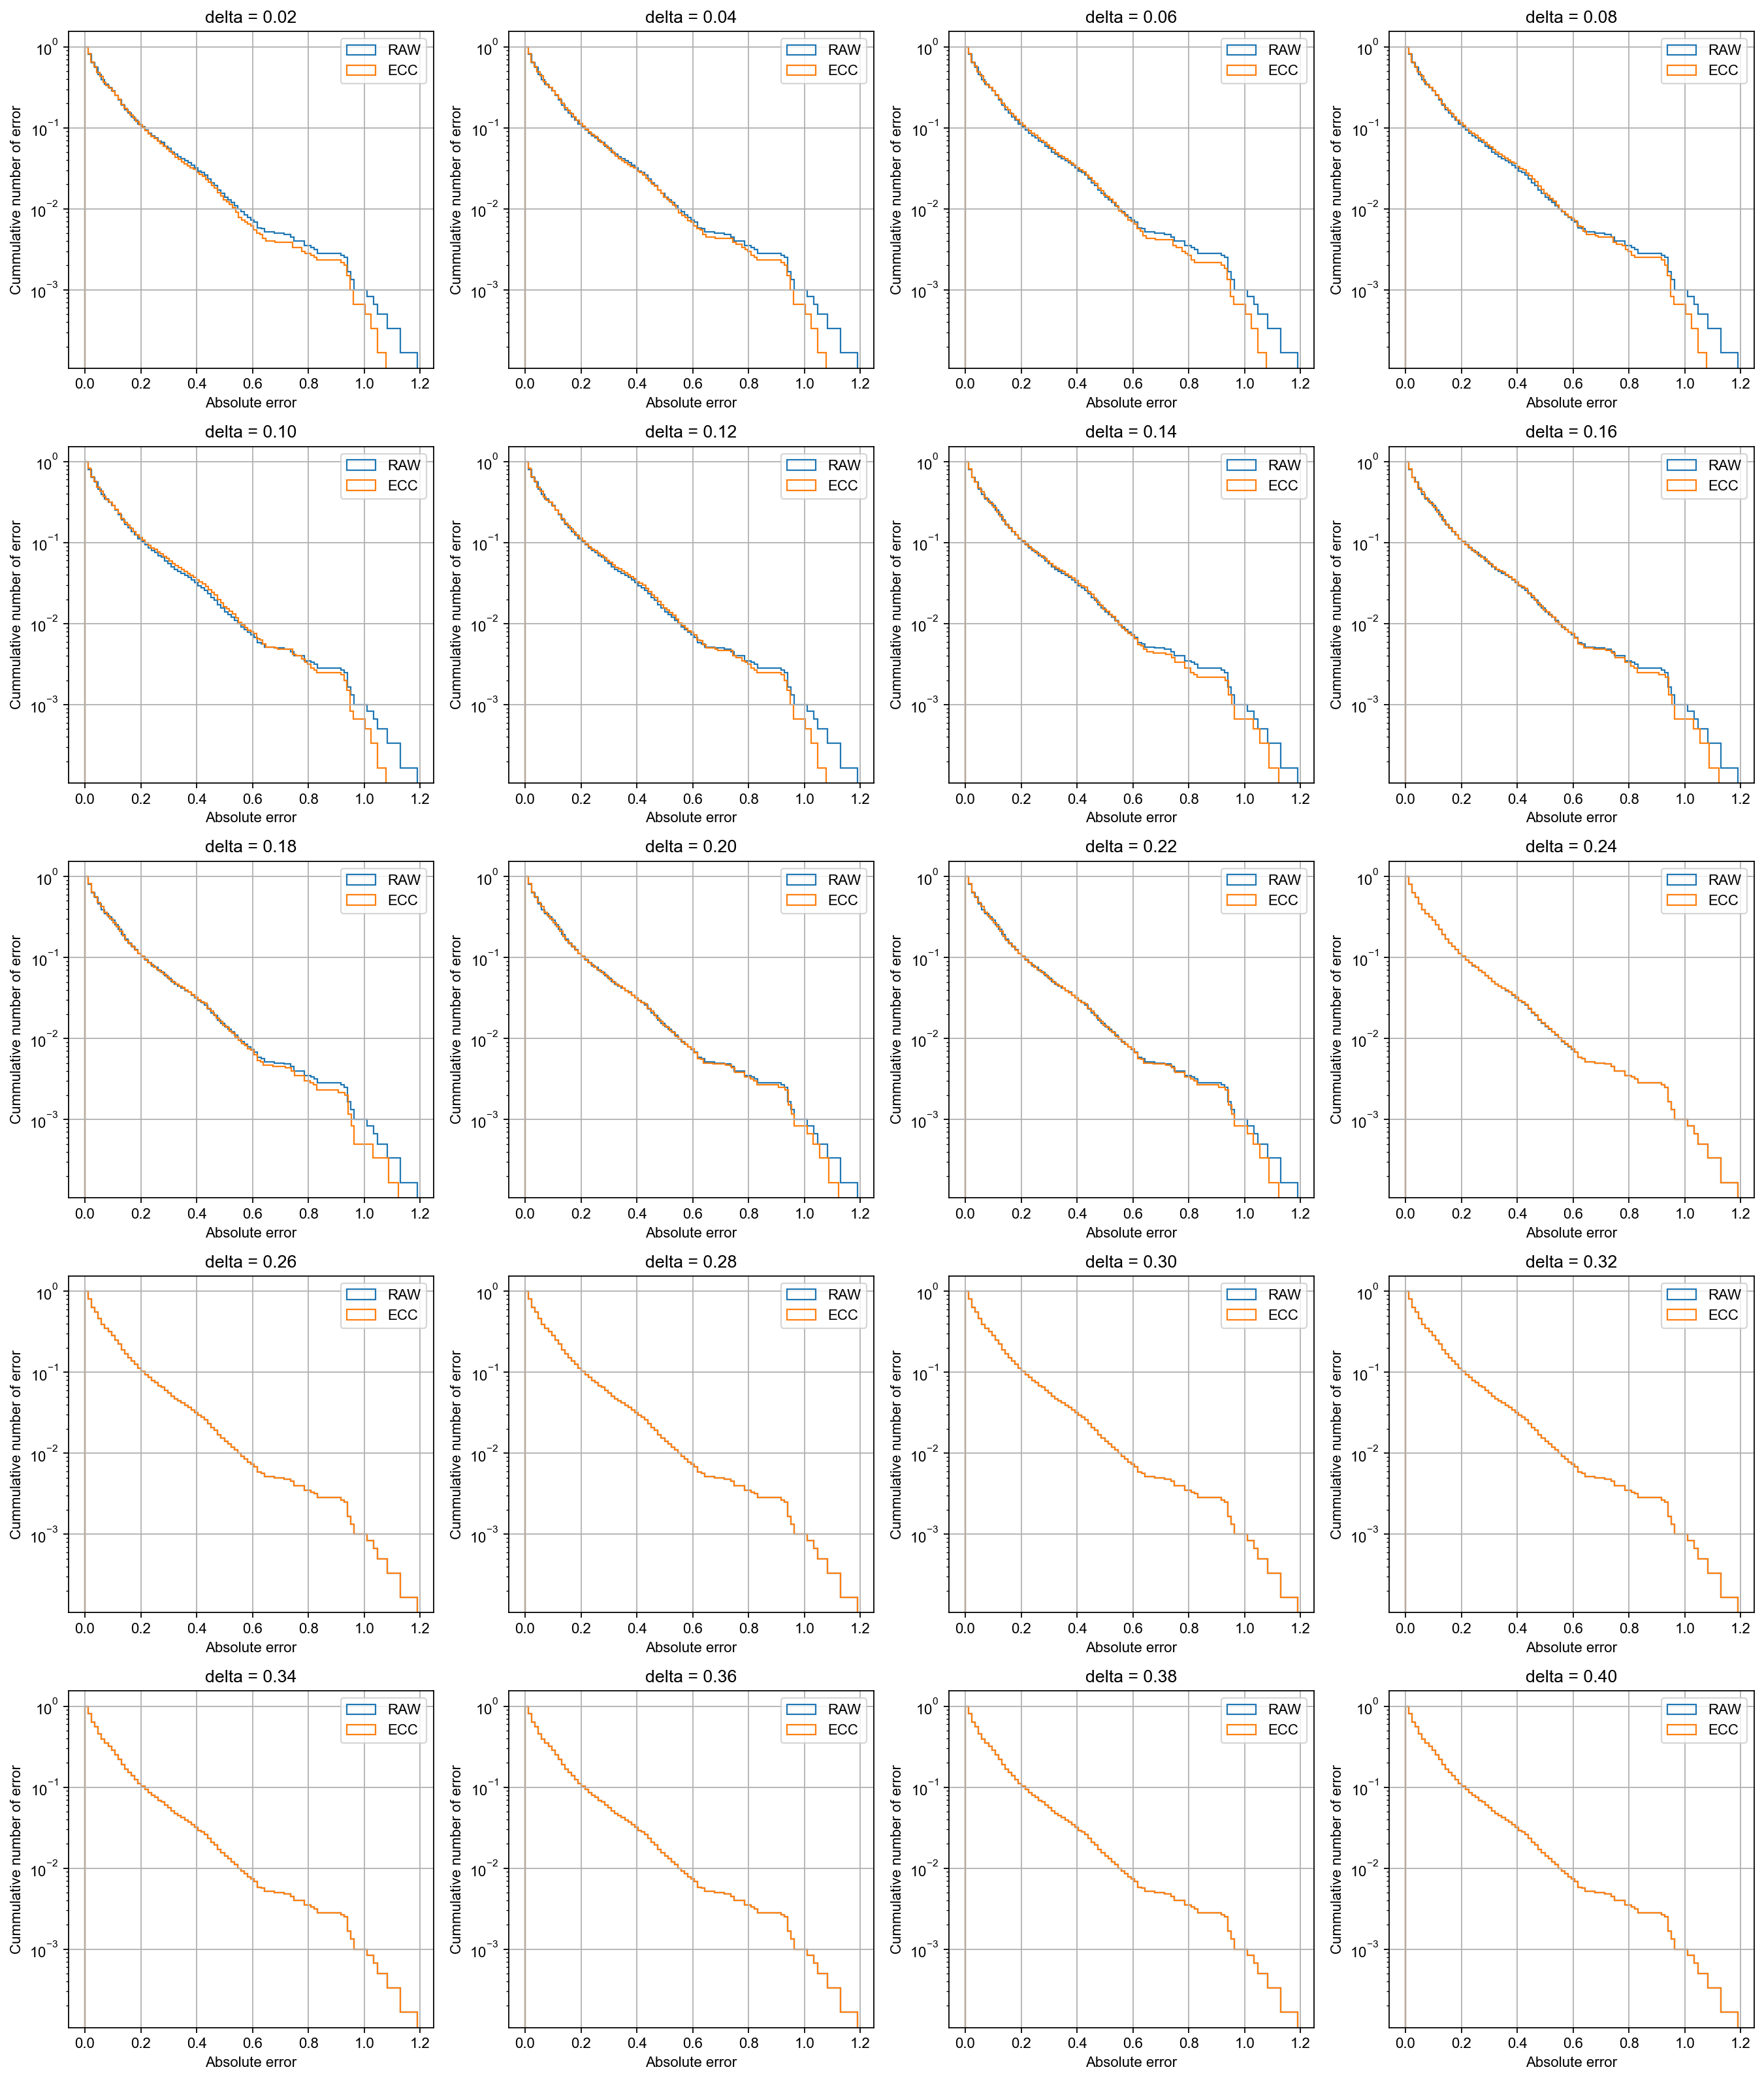

In [232]:
# output_soft = vectors.T @ G_conv_ecc / nn.Gratio
# y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

plt.figure(figsize=(17,20))

# for i in range(len(y1_list)):
for i in range(20):
    
    plt.subplot(5,4,i+1)

#     y1_raw = y1_raw_list[0]
    y1_ecc = y1_ecc_list_list[i]


    err_raw = (y1_raw - y1_soft).reshape(-1)
    err_ecc = (y1_ecc - y1_soft).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

## Add artifitial noise

In [236]:
y1_raw = y1_raw_list[0]

In [255]:
y1_noise = np.array(y1_raw.copy())

for r in range(y1_noise.shape[0]):
    c = int(y1_noise.shape[1] * np.random.rand())
    y1_noise[r,c] += np.random.randn() * 1

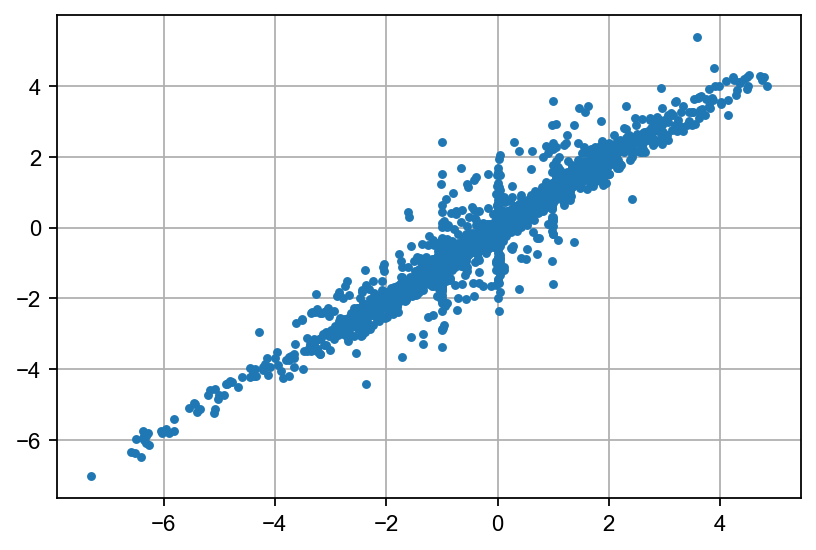

In [256]:
plt.plot(y1_soft.reshape(-1), y1_noise.reshape(-1), '.')

In [257]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list = []

for delta in tqdm(delta_list):
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

    y1_ecc_list.append( correct_ecc(y1_noise, ecc) )

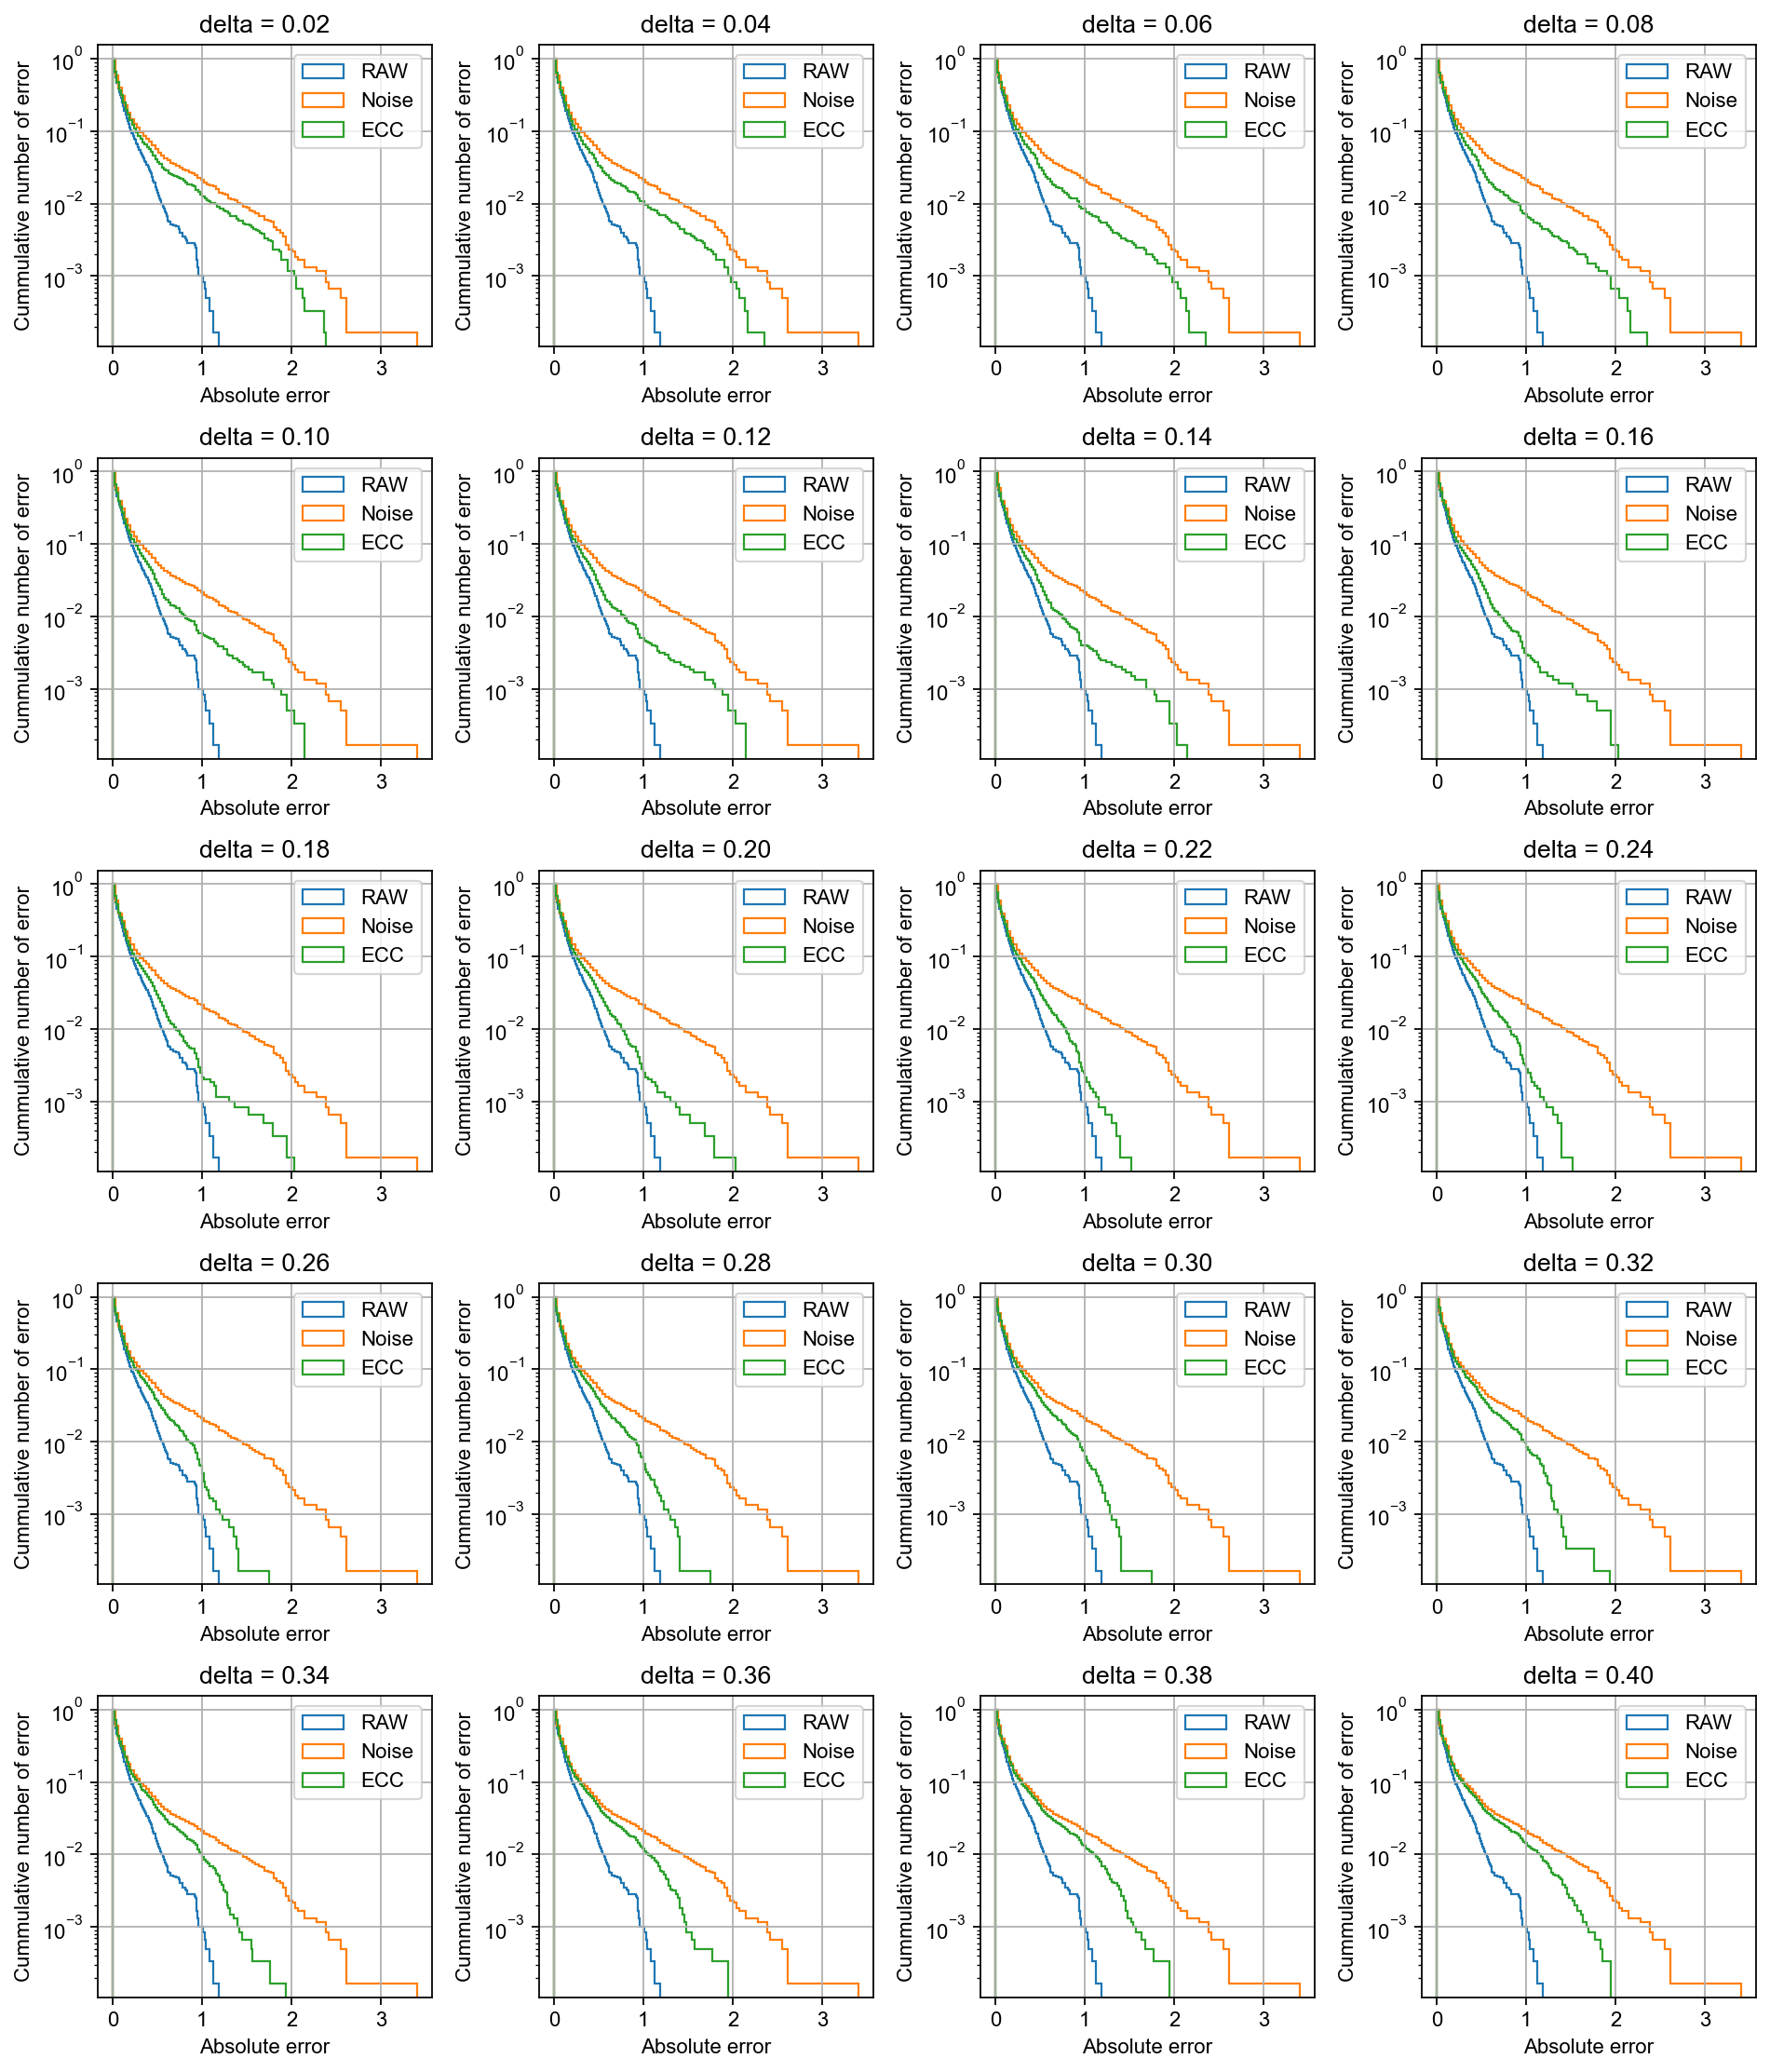

In [260]:
plt.figure(figsize=(12, 14))

for i in range(20):
    
    plt.subplot(5,4,i+1)

    y1_ecc = y1_ecc_list[i]

    err_raw = (y1_raw - y1_soft).reshape(-1)
    err_noise = (y1_noise - y1_soft).reshape(-1)
    err_ecc = (y1_ecc  - y1_soft).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_noise), density=True, histtype='step', cumulative=-1,
            label='Noise', bins=100)
    
    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

In [261]:
save_workspace(vars(), note='ecc-add-noise', skip_mat=True)

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), new_lin_cor_fc1(<class 'list'>), new_lin_cor_fc2(<class 'list'>), lin_cor_conv(<class 'list'>), finalGfc(<class 'numpy.ndarray'>), delta(<class 'numpy.float64'>), Delta(<class 'numpy.float64'>), m(<class 'int'>), k(<class 'int'>), M_conv_ecc(<class 'numpy.ndarray'>), G_conv_ecc(<class 'numpy.ndarray'>), G_parity_ecc(<class 'n